Import libs

In [1]:
from sklearn.metrics import f1_score, cohen_kappa_score, silhouette_score, matthews_corrcoef
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
import numpy as np
from bertopic.backend import MultiModalBackend
import warnings
import os 
warnings.filterwarnings('ignore')
import PIL.Image
import seaborn as sns
if not hasattr(PIL.Image, 'Resampling'):  # Pillow<9.0
    PIL.Image.Resampling = PIL.Image

import hdbscan
from hdbscan import HDBSCAN
from collections import Counter
from tqdm.notebook import tqdm

Load SM images

In [4]:
sm_df = pd.read_parquet(r"D:\Murgi\code\meme-evaluator\v3\holy_grail_all.parquet")
sm_df.drop(columns=['touch_binary','sparse_binary','phash_binary','cnn_binary','rnn_binary'], inplace=True)
sm_df

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,rnn_prediction,touch_prediction,path,phash
0,2021.11.15_889,templateless,0,templateless,templateless,scared-hamster,None,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,73e0d886a55e99b1
1,2021.11.19_551,templateless,0,templateless,templateless,templateless,None,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,f1c93e1e8f70c1e0
2,2021.11.20_438,templateless,0,can-i-offer-you-an-egg-in-these-trying-times,templateless,think-mark-think,None,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,1de50b0176b0eebc
3,2021.11.20_858,templateless,0,scumbag-brain,templateless,turn-up-the-volume,None,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,777c098782a9f259
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,None,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16
...,...,...,...,...,...,...,...,...,...,...
995,coronavirus-7244,templateless,0,templateless,templateless,templateless,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/coronavirus...,b31f52706cc76670
996,imemeit_added-15546,templateless,0,templateless,templateless,templateless,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,23d9caa73c1c87e2
997,imemeit_added-16353,templateless,0,templateless,templateless,keep-calm-and-carry-on-purple,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,2b83545abc0bd4bd
998,verynicememethanks_added-47232,templateless,0,templateless,templateless,wanted-poster,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/verynicemem...,1595ebb5b6914968


Embed SM images

In [5]:
import numpy as np
import os
from bertopic.backend import MultiModalBackend

store_path = r'D:\Murgi\code\memes2024\meme-research-2024\data\touch/1000sm_embeddings.npy'


if os.path.exists(store_path):
    print("Loading embeddings from disk...")
    sm_embeddings = np.load(store_path)
else:
    model = MultiModalBackend('clip-ViT-B-32', batch_size=32)

    img_paths = sm_df["path"].tolist()
    
    sm_embeddings = model.embed_images(img_paths, verbose=True)

    np.save(store_path, sm_embeddings)

print(sm_embeddings.shape)

100%|██████████| 32/32 [01:30<00:00,  2.82s/it]

(1000, 512)


Load fitted BERTopic model

In [6]:
model_path=  r"D:\Murgi\code\memes2024\meme-research-2024\data\touch\topic_model"

loaded_model = BERTopic.load(model_path)

Inference on SM images

In [7]:
documents = ["" for _ in range(sm_embeddings.shape[0])]

preds, _ = loaded_model.transform(documents=documents, embeddings=sm_embeddings)

In [8]:
len(preds)

1000

Decoding the predictions

In [12]:
cluster_df = pd.read_parquet(r'D:\Murgi\code\memes2024\meme-research-2024\data\touch\train_preds.parquet')
cluster_df.rename(columns={'id':'image_id', 'template_name':'template_true'}, inplace=True)
cluster_df

,image_id,template_true,template_id,template_cluster,newpath
index,,,,,
0,UNO-Draw-25-Cards_80,uno-draw-25-cards,1043.0,75,D:/Memes2024/UNO-Draw-25-Cards/UNO-Draw-25-Car...
1,Peter-parker-reading-a-book_32,peter-parker-reading-a-book,729.0,693,D:/Memes2024/Peter-parker-reading-a-book/Peter...
2,Daring-today-arent-we-squidward_3,daring-today-arent-we-squidward,243.0,2101,D:/Memes2024/Daring-today-arent-we-squidward/D...
3,Sidious-Error_63,sidious-error,847.0,988,D:/Memes2024/Sidious-Error/Sidious-Error_63.jpg
4,They-took-our-jobs-stance-South-Park_16,they-took-our-jobs-stance-south-park,989.0,-1,D:/Memes2024/They-took-our-jobs-stance-South-P...
...,...,...,...,...,...
1409095,2020_6-43958,None,NaN,-1,D:\Twitter2023\2020_6-43958.jpg
1409096,2020_6-43959,None,NaN,-1,D:\Twitter2023\2020_6-43959.jpg
1409097,2020_6-43960,None,NaN,-1,D:\Twitter2023\2020_6-43960.jpg


In [16]:
cluster_df = pd.concat([cluster_df, sm_df[['image_id','template_true','template_cluster','1000']]], ignore_index=True)
cluster_df

,image_id,template_true,template_id,template_cluster,newpath,1000
0,UNO-Draw-25-Cards_80,uno-draw-25-cards,1043.0,75,D:/Memes2024/UNO-Draw-25-Cards/UNO-Draw-25-Car...,NaN
1,Peter-parker-reading-a-book_32,peter-parker-reading-a-book,729.0,693,D:/Memes2024/Peter-parker-reading-a-book/Peter...,NaN
2,Daring-today-arent-we-squidward_3,daring-today-arent-we-squidward,243.0,2101,D:/Memes2024/Daring-today-arent-we-squidward/D...,NaN
3,Sidious-Error_63,sidious-error,847.0,988,D:/Memes2024/Sidious-Error/Sidious-Error_63.jpg,NaN
4,They-took-our-jobs-stance-South-Park_16,they-took-our-jobs-stance-south-park,989.0,-1,D:/Memes2024/They-took-our-jobs-stance-South-P...,NaN
...,...,...,...,...,...,...
1410095,coronavirus-7244,templateless,NaN,-1,NaN,True
1410096,imemeit_added-15546,templateless,NaN,581,NaN,True
1410097,imemeit_added-16353,templateless,NaN,-1,NaN,True
1410098,verynicememethanks_added-47232,templateless,NaN,-1,NaN,True


In [18]:
cluster_to_template = cluster_df.groupby('template_cluster')['template_true'].apply(list).to_dict()
cluster_to_template.pop(-1)

['they-took-our-jobs-stance-south-park',
 'the-what',
 'laughing-goat',
 'han-solo',
 'smash-bros',
 'crying-peter-parker',
 'anakin-kills-younglings',
 'kevin-hart',
 'sleeping-squidward',
 'inspirational-quote',
 'am-i-a-joke-to-you',
 'wolverine-remember',
 'spongebob-laughing-hysterically',
 'clown-computer',
 'am-i-a-joke-to-you',
 'maybe-i-am-a-monster',
 'wake-up-babe',
 'guy-recording-a-fight',
 'nick-young',
 'omg-cat',
 'yoda',
 'albert-einstein-quotes',
 'shocked-batman',
 'when-x-just-right',
 'angry-birds-pig',
 'stop-it-patrick-youre-scaring-him',
 'smash-bros',
 'anime-butterfly-meme',
 'one-does-not-simply',
 'smash-bros',
 'flooding-thumbs-up',
 'assassination-chain',
 'children-scared-of-rabbit',
 'third-world-skeptical-kid',
 'sad-baby',
 'look-marge',
 'ol-reliable',
 'frustrated-boromir',
 'weak-vs-strong-spongebob',
 'yall-got-any-more-of-that',
 'not-bad-obama',
 'small-face-romney',
 'hagrid-yer-a-wizard',
 'you-know-im-something-of-a--myself',
 'tier-list',
 'm

In [19]:
cluster_to_template[1]

['overjoyed',
 'keep-calm-and-carry-on-purple',
 'love',
 'love',
 'keep-calm-and-carry-on-purple',
 'keep-calm-and-carry-on-purple',
 'inspirational-quote',
 'inspirational-quote',
 'inspirational-quote',
 'keep-calm-and-carry-on-purple',
 'keep-calm-and-carry-on-purple',
 'inspirational-quote',
 'keep-calm-and-carry-on-purple',
 'keep-calm-and-carry-on-purple',
 'red-pill-blue-pill',
 'inspirational-quote',
 'blank-blue-background',
 'inspirational-quote',
 'love',
 'love',
 'keep-calm-and-carry-on-purple',
 'keep-calm-and-carry-on-purple',
 'inspirational-quote',
 'inspirational-quote',
 'inspirational-quote',
 'inspirational-quote',
 'inspirational-quote',
 'keep-calm-and-carry-on-purple',
 'inspirational-quote',
 'inspirational-quote',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 Non

In [20]:
def majority_voting(cluster_to_template):
    # Initialize an empty dictionary to store the majority label for each cluster
    majority_label_for_cluster = {}

    # Loop through the cluster_to_template dictionary
    for cluster_id, templates in cluster_to_template.items():
        # Count the occurrences of each template in the cluster
        template_counts = Counter(templates)
        
        # Find the most common template
        most_common_template, _ = template_counts.most_common(1)[0]

        # if most common template is NaN, then assign the second most common template
        if (pd.isnull(most_common_template)) or (most_common_template == None):
            try:
                most_common_template, _ = template_counts.most_common(2)[1]
            except:
                most_common_template = 'templateless'
        # Store the most common template as the 'predicted' label for the cluster
        majority_label_for_cluster[cluster_id] = most_common_template

    return majority_label_for_cluster

majority_label_for_cluster = majority_voting(cluster_to_template)

In [21]:
cluster_df['touch_prediction'] = cluster_df['template_cluster'].apply(lambda x: majority_label_for_cluster[x] if x in majority_label_for_cluster else "templateless")
y_pred = cluster_df['touch_prediction']

In [22]:
y_pred.value_counts()

touch_prediction
templateless             1034848
inspirational-quote         6160
happy-then-sad              6038
anime-butterfly-meme        5802
dj-pauly-d                  3868
                          ...   
my-beloved                    33
csi                           33
bill-oreilly                  33
i-hate-the-antichrist         32
inception                     32
Name: count, Length: 945, dtype: int64

In [23]:
df_1000 = cluster_df.loc[cluster_df['1000'] == True]
df_1000

,image_id,template_true,template_id,template_cluster,newpath,1000,touch_prediction
1409100,2021.11.15_889,templateless,NaN,-1,NaN,True,templateless
1409101,2021.11.19_551,templateless,NaN,498,NaN,True,templateless
1409102,2021.11.20_438,templateless,NaN,-1,NaN,True,templateless
1409103,2021.11.20_858,templateless,NaN,-1,NaN,True,templateless
1409104,2021.11.21_500,gus-fring-we-are-not-the-same,NaN,62,NaN,True,gus-fring-we-are-not-the-same
...,...,...,...,...,...,...,...
1410095,coronavirus-7244,templateless,NaN,-1,NaN,True,templateless
1410096,imemeit_added-15546,templateless,NaN,581,NaN,True,templateless
1410097,imemeit_added-16353,templateless,NaN,-1,NaN,True,templateless
1410098,verynicememethanks_added-47232,templateless,NaN,-1,NaN,True,templateless


In [28]:
sm_df.drop(columns=['template_cluster','1000'], inplace=True)
sm_df = sm_df.merge(df_1000[['image_id','touch_prediction']], on='image_id')
sm_df

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,rnn_prediction,touch_prediction_x,path,phash,touch_prediction_y
0,2021.11.15_889,templateless,0,templateless,templateless,scared-hamster,None,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,73e0d886a55e99b1,templateless
1,2021.11.19_551,templateless,0,templateless,templateless,templateless,None,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,f1c93e1e8f70c1e0,templateless
2,2021.11.20_438,templateless,0,can-i-offer-you-an-egg-in-these-trying-times,templateless,think-mark-think,None,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,1de50b0176b0eebc,templateless
3,2021.11.20_858,templateless,0,scumbag-brain,templateless,turn-up-the-volume,None,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,777c098782a9f259,templateless
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,None,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16,gus-fring-we-are-not-the-same
...,...,...,...,...,...,...,...,...,...,...,...
995,coronavirus-7244,templateless,0,templateless,templateless,templateless,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/coronavirus...,b31f52706cc76670,templateless
996,imemeit_added-15546,templateless,0,templateless,templateless,templateless,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,23d9caa73c1c87e2,templateless
997,imemeit_added-16353,templateless,0,templateless,templateless,keep-calm-and-carry-on-purple,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,2b83545abc0bd4bd,templateless
998,verynicememethanks_added-47232,templateless,0,templateless,templateless,wanted-poster,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/verynicemem...,1595ebb5b6914968,templateless


In [31]:
sm_df['touch_binary'] = sm_df['touch_prediction'].apply(lambda x: 0 if x == 'templateless' else 1)
sm_df

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,rnn_prediction,path,phash,touch_prediction,touch_binary
0,2021.11.15_889,templateless,0,templateless,templateless,scared-hamster,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,73e0d886a55e99b1,templateless,0
1,2021.11.19_551,templateless,0,templateless,templateless,templateless,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,f1c93e1e8f70c1e0,templateless,0
2,2021.11.20_438,templateless,0,can-i-offer-you-an-egg-in-these-trying-times,templateless,think-mark-think,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,1de50b0176b0eebc,templateless,0
3,2021.11.20_858,templateless,0,scumbag-brain,templateless,turn-up-the-volume,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,777c098782a9f259,templateless,0
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16,gus-fring-we-are-not-the-same,1
...,...,...,...,...,...,...,...,...,...,...,...
995,coronavirus-7244,templateless,0,templateless,templateless,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/coronavirus...,b31f52706cc76670,templateless,0
996,imemeit_added-15546,templateless,0,templateless,templateless,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,23d9caa73c1c87e2,templateless,0
997,imemeit_added-16353,templateless,0,templateless,templateless,keep-calm-and-carry-on-purple,templateless,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,2b83545abc0bd4bd,templateless,0
998,verynicememethanks_added-47232,templateless,0,templateless,templateless,wanted-poster,templateless,D:/Murgi/Facebook2023/Facebook2023/verynicemem...,1595ebb5b6914968,templateless,0


In [33]:
sm_df.loc[sm_df.template_true.str.startswith("case"),'touch_prediction'] = sm_df.loc[sm_df.template_true.str.startswith("case"),'touch_prediction'].apply(lambda x: "templateless" if x.startswith("case") else x)
sm_df.loc[sm_df.template_true.str.startswith("case")]

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,rnn_prediction,path,phash,touch_prediction,touch_binary
670,149781103607370_added-7706,case1 - kylo,1,oh-no,templateless,keep-calm-and-carry-on-purple,templateless,D:/Murgi/Facebook2023/Facebook2023/14978110360...,73a9cd1eeb562250,templateless,0
705,2019_12-13011,case1 - drake and josh,1,anakin-kills-younglings,templateless,black-girl-wat,templateless,D:/Murgi/Twitter2023/2019_12-13011.jpg,619d47f39d640e58,templateless,1
737,2019_6-12416,case1,1,templateless,templateless,for-christmas-i-want-a-dragon,templateless,D:/Murgi/Twitter2023/2019_6-12416.jpg,ab95c8d1432e966d,templateless,0
744,2019_6-24471,case1,1,templateless,templateless,templateless,templateless,D:/Murgi/Twitter2023/2019_6-24471.jpg,5b2515b6585e6687,templateless,0
748,2019_6-28766,case1,1,look-how-they-massacred-my-boy,templateless,templateless,templateless,D:/Murgi/Twitter2023/2019_6-28766.jpg,25250fdaa52dcc5e,templateless,1
753,2019_6-996,case1,1,templateless,templateless,peter-parker-cry,templateless,D:/Murgi/Twitter2023/2019_6-996.jpg,43ad4cb06c80f8ff,templateless,1
754,2020_6-10770,case1 - sacred text,1,beggar,templateless,limmy-waking-up,templateless,D:/Murgi/Twitter2023/2020_6-10770.jpg,5ff0c16eb0463dd0,templateless,0
768,2020_6-30879,case1 reality is often disappointing,1,depressed-cat,templateless,finally-inner-peace,templateless,D:/Murgi/Twitter2023/2020_6-30879.jpg,d7390156eed23929,i-am-inevitable,1
780,2020_6-9376,case1,1,sweating-bullets,templateless,black-scientist-finally-xium,templateless,D:/Murgi/Twitter2023/2020_6-9376.jpg,59496785b732dc4a,templateless,0
781,2021.11.14_473,case1,1,oh-no,templateless,templateless,templateless,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,fd07217c9f0863f0,templateless,0


In [35]:
sm_df['special_case'] = sm_df['template_true'].apply(lambda x: True if x.startswith('case') else False)
sm_df

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,rnn_prediction,path,phash,touch_prediction,touch_binary,special_case
0,2021.11.15_889,templateless,0,templateless,templateless,scared-hamster,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,73e0d886a55e99b1,templateless,0,False
1,2021.11.19_551,templateless,0,templateless,templateless,templateless,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,f1c93e1e8f70c1e0,templateless,0,False
2,2021.11.20_438,templateless,0,can-i-offer-you-an-egg-in-these-trying-times,templateless,think-mark-think,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,1de50b0176b0eebc,templateless,0,False
3,2021.11.20_858,templateless,0,scumbag-brain,templateless,turn-up-the-volume,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,777c098782a9f259,templateless,0,False
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16,gus-fring-we-are-not-the-same,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
995,coronavirus-7244,templateless,0,templateless,templateless,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/coronavirus...,b31f52706cc76670,templateless,0,False
996,imemeit_added-15546,templateless,0,templateless,templateless,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,23d9caa73c1c87e2,templateless,0,False
997,imemeit_added-16353,templateless,0,templateless,templateless,keep-calm-and-carry-on-purple,templateless,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,2b83545abc0bd4bd,templateless,0,False
998,verynicememethanks_added-47232,templateless,0,templateless,templateless,wanted-poster,templateless,D:/Murgi/Facebook2023/Facebook2023/verynicemem...,1595ebb5b6914968,templateless,0,False


In [ ]:
specials = sm_df.loc[sm_df['special_case'] == True,['image_id','path','template_true','touch_prediction']]

import matplotlib.pyplot as plt
for i, row in specials.iterrows():
    img = plt.imread(row['path'])
    plt.imshow(img)
    plt.title(f"Id: {row['image_id']} True: {row['template_true']}, Predicted: {row['touch_prediction']}")
    print((row['image_id'],row['touch_prediction']))
    plt.axis('off')
    plt.show()


Volt két olyan speckó eset amit a touch meg tudott találni az eddigiekkel ellentétben. Azokat most rendesen felcímkézzük.

In [26]:
good_preds = [('2022.05.14_233', 'the-office-handshake'),
              ('2022.07.05_818', 'joey-repeat-after-me')
              ]

for id, pred in good_preds:
    gt_df.loc[gt_df['id'] == id, ['template_name', 'binary_true_encoded', 'special_case']] = (pred, 1, False)

In [28]:
gt_df.rename(columns={'template_name':'template_true'}, inplace=True)

gt_df.to_parquet(r"D:\Murgi\code\meme-evaluator\holy_grail.parquet")

In [37]:
sm_df

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,rnn_prediction,path,phash,touch_prediction,touch_binary,special_case
0,2021.11.15_889,templateless,0,templateless,templateless,scared-hamster,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,73e0d886a55e99b1,templateless,0,False
1,2021.11.19_551,templateless,0,templateless,templateless,templateless,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,f1c93e1e8f70c1e0,templateless,0,False
2,2021.11.20_438,templateless,0,can-i-offer-you-an-egg-in-these-trying-times,templateless,think-mark-think,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,1de50b0176b0eebc,templateless,0,False
3,2021.11.20_858,templateless,0,scumbag-brain,templateless,turn-up-the-volume,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,777c098782a9f259,templateless,0,False
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16,gus-fring-we-are-not-the-same,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
995,coronavirus-7244,templateless,0,templateless,templateless,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/coronavirus...,b31f52706cc76670,templateless,0,False
996,imemeit_added-15546,templateless,0,templateless,templateless,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,23d9caa73c1c87e2,templateless,0,False
997,imemeit_added-16353,templateless,0,templateless,templateless,keep-calm-and-carry-on-purple,templateless,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,2b83545abc0bd4bd,templateless,0,False
998,verynicememethanks_added-47232,templateless,0,templateless,templateless,wanted-poster,templateless,D:/Murgi/Facebook2023/Facebook2023/verynicemem...,1595ebb5b6914968,templateless,0,False


              precision    recall  f1-score   support

           0       0.88      0.85      0.86       753
           1       0.59      0.64      0.61       247

    accuracy                           0.80      1000
   macro avg       0.73      0.75      0.74      1000
weighted avg       0.81      0.80      0.80      1000



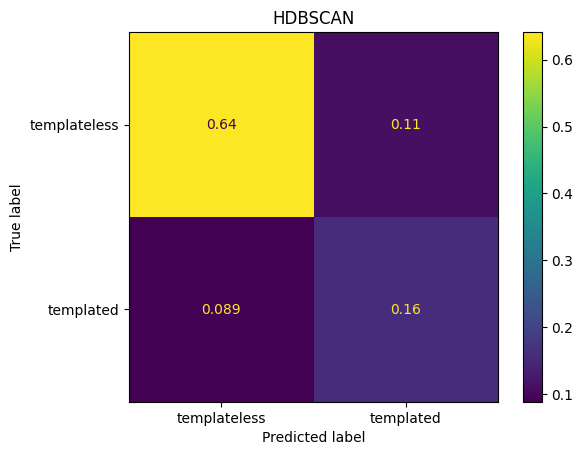

In [38]:
from sklearn.metrics import classification_report
# import confusion_matrix_pretty_print
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json 

print(classification_report(sm_df['binary_true_encoded'], sm_df['touch_binary']))
report = classification_report(sm_df['binary_true_encoded'], sm_df['touch_binary'], output_dict=True)
with open(f"D:\Murgi\code\memes2024\meme-research-2024/reports/binary-reports/1000-binary-report-hdbscan.json", "w") as f:
    json.dump(report, f, indent=4)

cm = confusion_matrix(sm_df['binary_true_encoded'], sm_df['touch_binary'], normalize="all")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['templateless', 'templated'])
disp.plot()
plt.title("HDBSCAN")
plt.show()

# Check the accuracy on memes that WE thought are templated

In [39]:
gt_df_true_templated = sm_df[sm_df['binary_true_encoded'] == 1]
gt_df_true_templated

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,rnn_prediction,path,phash,touch_prediction,touch_binary,special_case
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16,gus-fring-we-are-not-the-same,1,False
6,2021.11.21_977,gus-fring-we-are-not-the-same,1,templateless,templateless,gus-fring-we-are-not-the-same,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,c9db2674a1701797,gus-fring-we-are-not-the-same,1,False
13,2021.11.29_328,skeletor-disturbing-facts,1,templateless,skeletor-disturbing-facts,skeletor-disturbing-facts,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,4322a7fc7c67128b,skeletor-disturbing-facts,1,False
18,2021.12.06_275,you-guys-always-act-like-youre-better-than-me,1,nobody-absolutely-no-one,templateless,templateless,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,778824cf7e358952,templateless,0,False
23,2021.12.08_89,i-think-i-forgot-something,1,templateless,templateless,i-think-i-forgot-something,None,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,0f4dd212e9ec469d,templateless,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
911,444169716245436_added-13861,case1,1,maybe-i-am-a-monster,templateless,mom-can-we-have,templateless,D:/Murgi/Facebook2023/Facebook2023/44416971624...,35435bb024edd333,im-about-to-end-this-mans-whole-career,1,True
986,DankMagicMemes_added-10534,case1-spray kid,1,templateless,templateless,crying-wojak-vs-chad,templateless,D:/Murgi/Facebook2023/Facebook2023/DankMagicMe...,53cb2d45fa8256cc,templateless,0,True
989,DankMagicMemes_added-13013,case1,1,black-girl-wat,templateless,inception,templateless,D:/Murgi/Facebook2023/Facebook2023/DankMagicMe...,df11383d03df0a87,templateless,0,True
990,DankMagicMemes_added-13308,case1,1,matrix-morpheus-offer,templateless,oliver-twist-please-sir,liam-neeson-taken,D:/Murgi/Facebook2023/Facebook2023/DankMagicMe...,a3348bcaade1564b,pippin-second-breakfast,1,True


In [40]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, cohen_kappa_score

def calc_acc_for_templated_memes(df,model_name:str):
    temp = df
    y_true = temp['template_true'].values
    y_pred = temp[f"{model_name}_prediction"].values
    acc = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)
    return {'accuracy': acc, 'mcc': mcc, 'f1': f1, 'kappa': kappa}

print("Accuracy for templated memes without templateless")
print(calc_acc_for_templated_memes(gt_df_true_templated,"touch"))

print("Accuracy for all memes including templateless")
print(calc_acc_for_templated_memes(sm_df,"touch"))

Accuracy for templated memes without templateless
{'accuracy': 0.5060728744939271, 'mcc': 0.5500128574851347, 'f1': 0.5280667732680117, 'kappa': 0.503296630843278}
Accuracy for all memes including templateless
{'accuracy': 0.766, 'mcc': 0.4745874252931769, 'f1': 0.7749498881431767, 'kappa': 0.47376114603128194}


# Check the accuracy on memes that the MODELS thought are templated

In [41]:
def calc_accuracy_on_model_templated(temp, model_name):
    temp = temp[temp[f"{model_name}_prediction"] != 'templateless']
    y_true = temp['template_true'].values
    y_pred = temp[f"{model_name}_prediction"].values
    acc = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)
    return {'accuracy': acc, 'mcc': mcc, 'f1': f1, 'kappa': kappa}


print('Accuracy on only templated memes (defined by models):')
print(calc_accuracy_on_model_templated(sm_df,"touch"))

Accuracy on only templated memes (defined by models):
{'accuracy': 0.4752851711026616, 'mcc': 0.5238169548766264, 'f1': 0.46706500090530506, 'kappa': 0.47267787350894264}


In [43]:
all_memes_true_templated = calc_acc_for_templated_memes(sm_df,"touch")
only_templated_true_templated = calc_acc_for_templated_memes(gt_df_true_templated,"touch")
only_templated_model_templates = calc_accuracy_on_model_templated(sm_df,"touch")
multiclass_accs = {
    "all_memes_true_templated": all_memes_true_templated,
    "only_templated_true_templated": only_templated_true_templated,
    "only_templated_model_templates": only_templated_model_templates
}
with open(f"D:\Murgi\code\memes2024\meme-research-2024/reports\multiclass-reports/1000-multiclass-report-hdbscan.json", "w") as f:
    json.dump(multiclass_accs, f, indent=4)